# AutoEncoder with Generative Adversarial Network

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility 
manualSeed = 9999
# manualSeed = random.ranint(1, 10000) # use if we want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9999


In [2]:
# Root directory for dataset
dataroot = ".\celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64

# Number of channels in the training images.
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU.
ngpu = 1

CUDA is available!


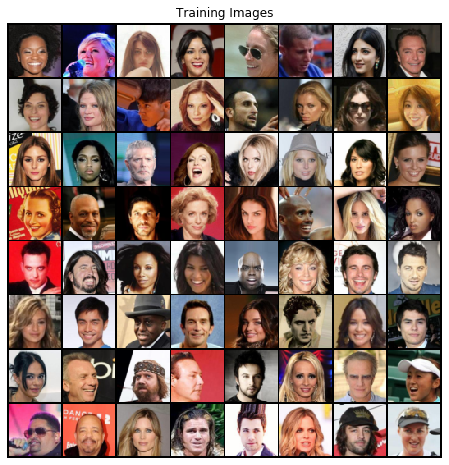

In [3]:
# Creating the dataset
dataset = dset.ImageFolder(root = dataroot, transform = transforms.Compose(([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
                                         num_workers = workers, drop_last=False) # remove drop_last

# Decide which device we want to run on
if torch.cuda.is_available():
    print("CUDA is available!")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(), (1,2,0)))

### Weight Initialisation

In [4]:
# custom weights initialisation called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        #print("")
        #print("Discriminator")
        #print(input.size())
        output = self.main(input)
        #print(output.size())
        return output

In [6]:
# Instantiating the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if required
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply thee weights_init function to randomly initialise all weights to mean = 0, stdev = 0.2
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### AutoEncoder

In [7]:
# class AE(nn.Module):
#     def __init__(self, ngpu):
#         super(AE, self).__init__()
#         self.ngpu = ngpu
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )
#         self.main(features) = nn.Sequential(
#             activation = self.encoder_hidden_layer(features)
#             activation = torch.relu(activation)
#             code = self.encoder_output_layer(activation)
#             code = torch.sigmoid(code)
#             activation = self.decoder_hidden_layer(code)
#             activation = torch.relu(activation)
#             activation = self.decoder_output_layer(activation)
#             reconstructed = torch.sigmoid(activation)
#             return reconstructed
#         )

#     def forward(self, features):
#         return self.main(features)
    
# class AE(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )
    
#     def forward(self, features):
#         activation = self.encoder_hidden_layer(features)
#         activation = torch.relu(activation)
#         code = self.encoder_output_layer(activation)
#         code = torch.sigmoid(code)
#         activation = self.decoder_hidden_layer(code)
#         activation = torch.relu(activation)
#         activation = self.decoder_output_layer(activation)
#         reconstructed = torch.sigmoid(activation)
#         return reconstructed

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, ngpu):
        super(AutoEncoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential( 
            nn.Linear(in_features = 64, out_features = 20, bias = False),
            nn.Linear(in_features = 20, out_features = 64, bias = False)
        )
    
    def forward(self, input):
       # print(input.size())
        #input = input.view(input.size(0), -1)
        output = self.main(input)
       # print(output.size())
        return output

In [9]:
# Instantiating the autoencoder
netAE = AutoEncoder(ngpu).to(device)

# Handle multi-gpu if required
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights initiliser function to randomly initialise all weights to mean=0, s.d.=0.2.
netAE.apply(weights_init)

# Print the model
print(netAE)

AutoEncoder(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=False)
    (1): Linear(in_features=20, out_features=64, bias=False)
  )
)


### Generator

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential( # Creates a ordered sequential container
  
            nn.ConvTranspose2d(3, nc, 4, 1, 1, bias=False)
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( 50, ngf * 8, 4, 1, 0, bias=False), #in_channels, out_channels, kernel_size, stride, padding
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
            
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
            
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
            
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
            
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
        )
    
    def forward(self, input):
       # print("")
       # print("Generator")
        #print(input.size())
        output = self.main(input)
        #print(output.size())
        return output

In [11]:
# Instantiating the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if required
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights initiliser function to randomly initialise all weights to mean=0, s.d.=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


In [12]:
# Initalise BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualise the progression of the generaator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerAE = optim.Adam(netAE.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [13]:
# Lists to keep track of progress
img_list = []
AE_losses = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop")

for epoch in range(num_epochs):
    # For each batch in datalodaer
    for i, data in enumerate(dataloader, 0):
        #################################################################
        # (1) Update Discriminator: maximise log(D(x)) + log(1-D(G(z))) #
        #################################################################
        
        ## Training with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass through
        output = netD(real_cpu).view(-1)
        # Calculate loss
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Training with all-fake batch
        
        #print("b_size is :", b_size)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        #print("noise size is :", noise.size())
        
        ## Get data
        real_data = data[0].to(device)
        #print(real_data.size())
        ae_data = netAE(real_data)
        fake = netG(ae_data)
#         # Generating batch of latent vectors i.e. random noise
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         # Generating fake image batch using Generator with noise
#         fake = netG(noise)
        label.fill_(fake_label) # Fills labels with it being fake
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        #torch.set_printoptions(profile="full")
        #print(output)
        #torch.set_printoptions(profile="default")
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        ## Add the gradients from the all-real and all-fake batches and update the Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ###############################################
        # (2) Update Generator: maximise log(D(G(z))) #
        ###############################################
        
        netAE.zero_grad()
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        
        # Since we just updated the Discriminator, we perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1) # fake values already generated above for D pass
        # Calculate Generator's loss from this
        errG = criterion(output, label)
        errAE = criterion(output, label)
        # Calculate gradients for G
        
        errG.backward(retain_graph = True)
        D_G_z2 = output.mean().item()
        errAE.backward()
        # Update Generator
        optimizerG.step()
        optimizerAE.step()
        
        #########################
        # Output Training Stats #
        #########################
        if i % 50 == 0:
            #errAE = errG
            print ('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_AE: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), errAE.item(),
                    D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        AE_losses.append(errAE.item())
        
        # Check how the generator is doing by saving its output on fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(ae_data).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize = True))
            
        iters += 1

Starting Training Loop


..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/5][0/1583]	Loss_D: 2.1552	Loss_G: 8.3903	Loss_AE: 8.3903	D(x): 0.8406	D(G(z)): 0.8076 / 0.0154
[0/5][50/1583]	Loss_D: 0.0040	Loss_G: 7.1902	Loss_AE: 7.1902	D(x): 0.9985	D(G(z)): 0.0025 / 0.0018
[0/5][100/1583]	Loss_D: 0.0024	Loss_G: 7.3641	Loss_AE: 7.3641	D(x): 0.9996	D(G(z)): 0.0020 / 0.0015


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()